# Comparative Analysis of Ensemble Methods for Predicting Antibody Titers

Author: Elias Dams

Date: 2 Dec 2024

Implement and Compare Ensemble Methods:
- Apply different ensemble learning techniques to predict antibody titers.
- Evaluate the performance of each method on individual datasets.
Identify the Best Predictive Model:
- Determine which method or combination of methods provides the highest accuracy.
- Assess whether integrating multiple data types improves predictions.

### Methods Overview
#### 1. Consensus Between Different Models
Description: Combine predictions from multiple models to reach a consensus decision. This can be achieved through techniques like majority voting for classification or averaging for regression tasks.
Purpose: To reduce individual model biases and variance by aggregating multiple model outputs, potentially leading to improved generalization on unseen data.

#### 2. Stacking Classifiers
Description: An ensemble technique where multiple base classifiers are trained, and a meta-classifier is then trained on their outputs to make the final prediction.
Purpose: To leverage the strengths of various algorithms by combining their predictions in a way that the meta-classifier can correct their individual weaknesses.

#### 3. Cascading Models:
Description: Sequentially apply models where the output of one model serves as the input for the next. This approach can be thought of as creating a pipeline of models that refine predictions progressively.
Purpose: To capture complex patterns by allowing subsequent models to learn from the residuals or errors of previous models, enhancing overall predictive capability.

#### 4. Multiple Kernel Learning
Description: An extension of kernel-based algorithms (e.g., Support Vector Machines) that utilizes multiple kernel functions to handle heterogeneous data sources. Each kernel can capture different data characteristics.
Purpose: To effectively integrate and learn from diverse data types by optimizing the combination of kernels, thereby improving model performance on complex datasets.



In [405]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from scipy.stats import mode
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer, balanced_accuracy_score

In [406]:
# Load the antibody titers data (response profile)
abtiters = pd.read_csv('../data/antibody_df.csv')
print("Antibody titers data loaded. Shape:", abtiters.shape)
print(abtiters.head())

# Load the cytokines data
cytokines = pd.read_csv('../data/cytokines_data.csv')
print("Cytokines data loaded. Shape:", cytokines.shape)
print(cytokines.head())

# Load the cytometry data
cytometry = pd.read_csv('../data/cyto_data.csv')
print("Cytometry data loaded. Shape:", cytometry.shape)
print(cytometry.head())

# Load clonal breadth data
clonal_breadth = pd.read_csv('../data/clonal_breadth_data.csv')
print("Clonal breadth data loaded. Shape:", clonal_breadth.shape)
print(clonal_breadth.head())
# How many different TCR clonotypes (unique combinations of sequences, V/J genes, etc.) are specific to measles.

# Load clonal depth data
clonal_depth = pd.read_csv('../data/clonal_depth_data.csv')
print("Clonal depth data loaded. Shape:", clonal_depth.shape)
print(clonal_depth.head())
# The ratio of unique beta-chain sequences predicted to bind measles to the total number of clonotypes. 
# This focuses on the most important part of the TCR (the beta chain).

# Load the module scores
module_scores = pd.read_csv('../data/module_scores_model_input_all.csv') #calculate for Hepatitis B data
print("Module scores loaded. Shape:", module_scores.shape)
print(module_scores.head())

# Check the distribution of module scores
print("Module score columns:", module_scores.columns[1:10])

datasets = {
    "antibody_titers": abtiters,
    "cytokines": cytokines,
    "cytometry": cytometry,
    "clonal_breadth": clonal_breadth,
    "clonal_depth": clonal_depth,
    "RNa_data": module_scores,
}

Antibody titers data loaded. Shape: (40, 12)
        vaccine Vaccinee  Day 0  Day 21  Day 150  Day 365  diff: 21-0  \
0  Anti-Measles       M1    5.0   217.0     30.8     31.5       212.0   
1  Anti-Measles      M11   17.9    30.1    300.0    214.0        12.2   
2  Anti-Measles      M12  300.0   300.0    300.0    300.0         0.0   
3  Anti-Measles      M13  227.0   300.0    236.0    300.0        73.0   
4  Anti-Measles      M14   26.7   261.0    276.0    300.0       234.3   

   diff: 150-21  diff: 365-150  response  protected               quadrant  
0        -186.2            0.7      True       True              responder  
1         269.9          -86.0     False      False   no response - low ab  
2           0.0            0.0     False       True  no response - high ab  
3         -64.0           64.0     False       True  no response - high ab  
4          15.0           24.0      True       True              responder  
Cytokines data loaded. Shape: (40, 41)
  Vaccinee  CMV


Frequency of responses:
response_label
no response    29
response       11
Name: count, dtype: int64


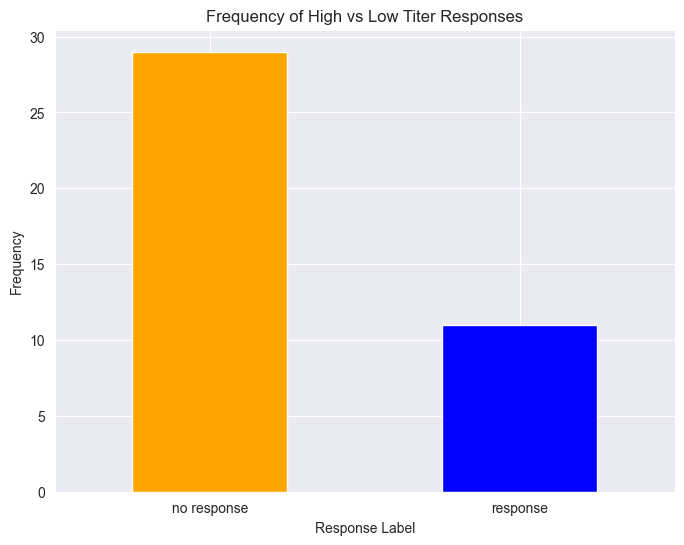

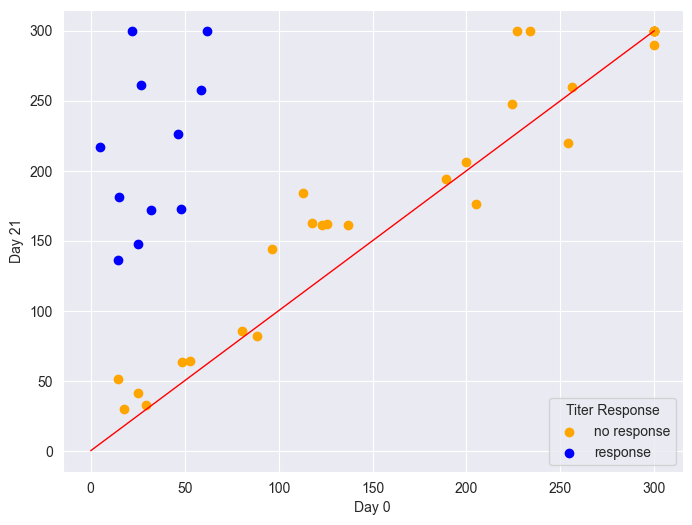

In [407]:
# Count the frequency of each label
abtiters['response_label'] = abtiters['quadrant'].apply(lambda x: 'response' if x == 'responder' else 'no response')

# Count the frequency of each label
response_counts = abtiters['response_label'].value_counts()

print("\nFrequency of responses:")
print(response_counts)

# Plot the frequency of high vs. low responses as a bar plot
plt.figure(figsize=(8, 6))
response_counts.plot(kind='bar', color=['orange', 'blue'])
plt.title('Frequency of High vs Low Titer Responses')
plt.xlabel('Response Label')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

colors = {'response': 'blue', 'no response': 'orange'}
plt.figure(figsize=(8, 6))
for label, group in abtiters.groupby('response_label'):
    plt.scatter(group['Day 0'], group['Day 21'], color=colors[label], label=label)

# Plot reference line y = x
plt.plot([0, max(abtiters['Day 0'])], [0, max(abtiters['Day 21'])], color='red', linestyle='-', linewidth=1)

# Labeling and legend
plt.xlabel('Day 0')
plt.ylabel('Day 21')
plt.legend(title="Titer Response")
plt.show()

In [408]:
abtiters = abtiters.drop(columns=['vaccine', 'Day 0', 'Day 21', 'Day 150', 'Day 365', 'diff: 21-0', 'diff: 150-21', 'diff: 365-150', 'response', 'protected','quadrant'])
## cytokines already loaded ##
cytometry = cytometry[['Vaccinee', 'WBC Day 0','RBC Day 0','HGB Day 0','HCT Day 0','PLT Day 0','%LYM Day 0','%MON Day 0','%GRA Day 0']]

datasets['antibody_titers'] = abtiters
datasets['cytometry'] = cytometry

### calculate a module score and comapare

In [409]:
def create_RNa_module_scores(read_count_path, module_scores_path, output_path_path):

    # Load data
    read_counts = pd.read_csv(read_count_path, index_col=0)  # Patients as rows, genes as columns
    module_list = pd.read_csv(module_scores_path)  # Contains columns 'Module', 'Gene', 'Function'
    
    # Ensure columns are strings for consistency
    read_counts.columns = read_counts.columns.astype(str)
    
    module_scores = []

    for module in module_list['Module'].unique():
        # Get the module's function
        module_function = module_list.loc[module_list['Module'] == module, 'Function'].iloc[0]
        module_genes = module_list[module_list['Module'] == module]['Gene']
        common_genes = [gene for gene in module_genes if gene in read_counts.columns]
    
        if not common_genes:
            print(f"No overlapping genes found for module {module}. Skipping.")
            continue
    
        # Subset read_counts for the genes in this module
        module_data = read_counts[common_genes]
        
        # Standardize the data
        scaler = StandardScaler()
        standardized_data = scaler.fit_transform(module_data)
        
        # Perform 1D PCA
        pca = PCA(n_components=1)
        pca_scores = pca.fit_transform(standardized_data)
        
        # Store results with module name and function
        module_scores.append(pd.DataFrame(
            pca_scores,
            index=read_counts.index,
            columns=[f"{module}.{module_function}"]
        ))
    
    # Combine all module scores into a single DataFrame
    module_scores_df = pd.concat(module_scores, axis=1)
    module_scores_df = module_scores_df.copy()
    
    # ---- pivoting logic -----
    
    # Extract 'Vaccinee' and 'TimePoint' from the index
    module_scores_df['TimePoint'] = module_scores_df.index.str.extract(r'_EXP(\d+)$', expand=False)
    module_scores_df['Vaccinee'] = module_scores_df.index.str.replace(r'_EXP\d+$', '', regex=True)
    
    # Reshape the data from long to wide format
    module_scores_df.reset_index(drop=True, inplace=True)  # Remove the old index
    wide_format = module_scores_df.pivot(index='Vaccinee', columns='TimePoint')
    
    # Flatten the MultiIndex in columns
    wide_format.columns = [
        f"{col[0]}_EXP{col[1]}" for col in wide_format.columns
    ]
    
    # Reset index to make 'Vaccinee' a column
    wide_format.reset_index(inplace=True)
    
    # Save the transformed data
    wide_format.to_csv(output_path_path, index=False)
    print(f"Transformed data saved as '{output_path_path}'")

In [410]:
create_RNa_module_scores(read_count_path = "../data/processed_readcounts_collapsed.csv", 
                         module_scores_path= "../data/module_list.csv", 
                         output_path_path= "../data_created/module_scores_model_input_all_self_made.csv")

rna_data = pd.read_csv("../data_created/module_scores_model_input_all_self_made.csv")
datasets["RNa_data"] = rna_data

Transformed data saved as '../data_created/module_scores_model_input_all_self_made.csv'


### 1. Consensus Between Different Models

In [411]:
# Merge datasets with the labels
cytokines_merged = pd.merge(datasets['antibody_titers'], datasets['cytokines'], on='Vaccinee')
cytometry_merged = pd.merge(datasets['antibody_titers'], datasets['cytometry'], on='Vaccinee')
#clonal_breadth_merged = pd.merge(datasets['antibody_titers'], datasets['clonal_breadth'], on='Vaccinee') #for now because they only contain 27 values
#clonal_depth_merged = pd.merge(datasets['antibody_titers'], datasets['clonal_depth'], on='Vaccinee') #for now because they only contain 27 values
rna_merged = pd.merge(datasets['antibody_titers'], datasets['RNa_data'], on='Vaccinee')

In [412]:
# Function to check missing values
def check_missing_values(df, dataset_name):
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if not missing.empty:
        print(f"Missing values in {dataset_name}:")
        print(missing)
    else:
        print(f"No missing values in {dataset_name}.")

# Check for missing values
check_missing_values(cytokines_merged, 'Cytokines Merged')
check_missing_values(cytometry_merged, 'Cytometry Merged')
#check_missing_values(clonal_breadth_merged, 'Clonal Breadth Merged')
#check_missing_values(clonal_depth_merged, 'Clonal Depth Merged')
check_missing_values(rna_merged, 'RNA Merged')

No missing values in Cytokines Merged.
No missing values in Cytometry Merged.
No missing values in RNA Merged.


In [413]:
#TODO look at correlations and compress data

In [414]:
def encode_labels(df):
    le = LabelEncoder()
    df['response_label'] = le.fit_transform(df['response_label'])
    return df

# Encode labels if necessary
cytokines_merged = encode_labels(cytokines_merged)
cytometry_merged = encode_labels(cytometry_merged)
# clonal_breadth_merged = encode_labels(clonal_breadth_merged)
# clonal_depth_merged = encode_labels(clonal_depth_merged)
rna_merged = encode_labels(rna_merged)

In [415]:
# Let's get the list of vaccinees to use as indices

balanced_test_set = False
if not balanced_test_set:
    # to just shiffle randomly
    vaccinees = abtiters['Vaccinee']
    train_vaccinees, test_vaccinees = train_test_split(vaccinees, test_size=0.2, random_state=42, stratify=abtiters['response_label'])
else:
    # Define the desired number of samples per class in the test set
    test_samples_per_class = 4  # 4 positive + 4 negative = 8 total
    
    # Separate positive and negative samples
    positive_samples = abtiters[abtiters['response_label'] == 'response']
    negative_samples = abtiters[abtiters['response_label'] == 'no response']
    
    # Ensure there are enough samples to meet the requirement
    assert len(positive_samples) >= test_samples_per_class, "Not enough positive samples for the test set"
    assert len(negative_samples) >= test_samples_per_class, "Not enough negative samples for the test set"
    
    # Randomly sample the test set for each class
    pos_test = positive_samples.sample(n=test_samples_per_class, random_state=42)
    neg_test = negative_samples.sample(n=test_samples_per_class, random_state=42)
    
    # Define the test set by combining positive and negative samples
    test_set = pd.concat([pos_test, neg_test])
    
    # Define the train set by excluding the test samples
    train_set = abtiters.drop(test_set.index)
    
    # Shuffle the train and test sets to ensure randomness
    train_set = train_set.sample(frac=1, random_state=42)
    test_set = test_set.sample(frac=1, random_state=42)
    
    train_vaccinees = pd.Series(train_set['Vaccinee'].values, index=train_set.index, name="Train Vaccinee")
    test_vaccinees = pd.Series(test_set['Vaccinee'].values, index=test_set.index, name="Test Vaccinee")
    
    # Print distributions for verification
    print("Train set distribution:")
    print(train_set['response_label'].value_counts())
    print("\nTest set distribution:")
    print(test_set['response_label'].value_counts())

def split_dataset(df, oversampling_method = None):
    # Use the pre-defined train and test vaccinees
    train_df = df[df['Vaccinee'].isin(train_vaccinees)]
    test_df = df[df['Vaccinee'].isin(test_vaccinees)]
    
    # Separate features and labels
    X_train = train_df.drop(['Vaccinee', 'response_label'], axis=1)
    y_train = train_df['response_label']
    X_test = test_df.drop(['Vaccinee', 'response_label'], axis=1)
    y_test = test_df['response_label']
    
    X_train_resampled = None
    y_train_resampled = None
    
    if oversampling_method is not None:
        if oversampling_method == 'smote':
            # Perform oversampling on the training data
            sm = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
        
        elif oversampling_method == 'random':
            # Perform random oversampling on the training data (simply duplicates existing minority class samples)
            ros = RandomOverSampler(random_state=42)
            X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
        # After oversampling
        print(f"Resampled class distribution using {oversampling_method}: {Counter(y_train_resampled)}")
    else:
        X_train_resampled = X_train
        y_train_resampled = y_train
    
        
    
    return X_train_resampled, X_test, y_train_resampled, y_test

# Split each dataset
X_train_cyto, X_test_cyto, y_train_cyto, y_test_cyto = split_dataset(cytokines_merged, oversampling_method='smote')
X_train_cytom, X_test_cytom, y_train_cytom, y_test_cytom = split_dataset(cytometry_merged, oversampling_method='smote')
# X_train_cb, X_test_cb, y_train_cb, y_test_cb = split_dataset(clonal_breadth_merged, oversampling_method='smote')
# X_train_cd, X_test_cd, y_train_cd, y_test_cd = split_dataset(clonal_depth_merged, oversampling_method='smote')
X_train_rna, X_test_rna, y_train_rna, y_test_rna = split_dataset(rna_merged, oversampling_method='smote')


Resampled class distribution using smote: Counter({1: 23, 0: 23})
Resampled class distribution using smote: Counter({1: 23, 0: 23})
Resampled class distribution using smote: Counter({1: 23, 0: 23})


In [416]:
scaler = StandardScaler()

def scale_features(X_train, X_test):
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# Scale features
X_train_cyto_scaled, X_test_cyto_scaled = scale_features(X_train_cyto, X_test_cyto)
X_train_cytom_scaled, X_test_cytom_scaled = scale_features(X_train_cytom, X_test_cytom)
# X_train_cb_scaled, X_test_cb_scaled = scale_features(X_train_cb, X_test_cb)
# X_train_cd_scaled, X_test_cd_scaled = scale_features(X_train_cd, X_test_cd)
X_train_rna_scaled, X_test_rna_scaled = scale_features(X_train_rna, X_test_rna)

In [417]:
from sklearn.model_selection import cross_val_score

def train_and_predict_best_model(X_train, y_train, X_test, data_name):
    import warnings
    warnings.filterwarnings('ignore')
    
    # Define models with balanced class weights where applicable
    models = {
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        'SVM': SVC(random_state=42, class_weight='balanced', probability=True),
        'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        'KNN': KNeighborsClassifier(),
        'Naive Bayes': GaussianNB()
    }
    
    # Initialize variables to store the best model
    best_score = -1
    best_model = None
    best_model_name = None
    
    # Define Leave-One-Out Cross-Validation
    loo = LeaveOneOut()
    
    # Define balanced accuracy scorer
    scoring = make_scorer(balanced_accuracy_score)
    
    for name, model in models.items():
        scores = cross_val_score(model, X_train, y_train, cv=loo, scoring=scoring)
        score = scores.mean()
        estimator = model.fit(X_train, y_train)
        
        # Update the best model if current model has a higher score
        if score > best_score:
            best_score = score
            best_model = estimator
            best_model_name = name
    
    # Print the best model details
    print(f"Best model for '{data_name}': {best_model_name} with balanced accuracy {best_score:.4f}")
    
    # Predict using the best model on the entire dataset
    y_pred = best_model.predict(X_test)
    
    return y_pred, best_model_name, best_model

y_pred_cyto, _, _ = train_and_predict_best_model(X_train_cyto_scaled, y_train_cyto, X_test_cyto_scaled, "cytokines")
y_pred_cytom, _, _ = train_and_predict_best_model(X_train_cytom_scaled, y_train_cytom, X_test_cytom_scaled, "cytometry")
# y_pred_cb, _, _ = train_and_predict_best_model(X_train_cb_scaled, y_train_cb, X_test_cb_scaled, "clonal breadth")
# y_pred_cd, _, _ = train_and_predict_best_model(X_train_cd_scaled, y_train_cd, X_test_cd_scaled, "clonal depth")
y_pred_rna, _, _ = train_and_predict_best_model(X_train_rna_scaled, y_train_rna, X_test_rna_scaled, "rna")

Best model for 'cytokines': Random Forest with balanced accuracy 0.8043
Best model for 'cytometry': Naive Bayes with balanced accuracy 0.8478
Best model for 'rna': Decision Tree with balanced accuracy 0.8696


In [418]:
# Stack predictions
predictions = np.column_stack((y_pred_cyto, y_pred_cytom, y_pred_rna)) #  y_pred_cb, y_pred_cd

# Majority vote
y_pred_consensus, _ = mode(predictions, axis=1)
y_pred_consensus = y_pred_consensus.ravel()

In [419]:
def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"{model_name} Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}\n")

In [420]:
y_test = y_test_cyto.values # Because they are all e the same

In [421]:
# Evaluate separate models
evaluate_model(y_test, y_pred_cyto, 'Cytokines Model')
evaluate_model(y_test, y_pred_cytom, 'Cytometry Model')
# evaluate_model(y_test, y_pred_cb, 'Clonal Breadth Model')
# evaluate_model(y_test, y_pred_cd, 'Clonal Depth Model')
evaluate_model(y_test, y_pred_rna, 'RNA Data Model')

# Evaluate consensus model
evaluate_model(y_test, y_pred_consensus, 'Consensus Model')

print(f"truth:\t\t { y_test_cyto.values }")
print(f"cytokines: { y_pred_cyto }")
print(f"cytometry: { y_pred_cytom }")
print(f"rna:\t\t\t { y_pred_rna }")
print(f"Consensus: { y_pred_consensus }")


Cytokines Model Performance:
Accuracy: 0.7500
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000

Cytometry Model Performance:
Accuracy: 0.8750
Precision: 1.0000
Recall: 0.5000
F1-Score: 0.6667

RNA Data Model Performance:
Accuracy: 0.7500
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000

Consensus Model Performance:
Accuracy: 0.7500
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000

truth:		 [0 0 0 0 0 0 1 1]
cytokines: [0 0 0 0 0 0 0 0]
cytometry: [0 0 0 0 0 0 0 1]
rna:			 [0 0 0 0 0 0 0 0]
Consensus: [0 0 0 0 0 0 0 0]


In [422]:
results = pd.DataFrame({
    'Model': ['Cytokines', 'Cytometry', 'RNA Data', 'Consensus'], # 'Clonal Breadth', 'Clonal Depth'
    'Accuracy': [
        accuracy_score(y_test, y_pred_cyto),
        accuracy_score(y_test, y_pred_cytom),
        # accuracy_score(y_test, y_pred_cb),
        # accuracy_score(y_test, y_pred_cd),
        accuracy_score(y_test, y_pred_rna),
        accuracy_score(y_test, y_pred_consensus)
    ],
    'Precision': [
        precision_score(y_test, y_pred_cyto, zero_division=0),
        precision_score(y_test, y_pred_cytom, zero_division=0),
        # precision_score(y_test, y_pred_cb, zero_division=0),
        # precision_score(y_test, y_pred_cd, zero_division=0),
        precision_score(y_test, y_pred_rna, zero_division=0),
        precision_score(y_test, y_pred_consensus, zero_division=0)
    ],
    'Recall': [
        recall_score(y_test, y_pred_cyto, zero_division=0),
        recall_score(y_test, y_pred_cytom, zero_division=0),
        # recall_score(y_test, y_pred_cb, zero_division=0),
        # recall_score(y_test, y_pred_cd, zero_division=0),
        recall_score(y_test, y_pred_rna, zero_division=0),
        recall_score(y_test, y_pred_consensus, zero_division=0)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_cyto, zero_division=0),
        f1_score(y_test, y_pred_cytom, zero_division=0),
        # f1_score(y_test, y_pred_cb, zero_division=0),
        # f1_score(y_test, y_pred_cd, zero_division=0),
        f1_score(y_test, y_pred_rna, zero_division=0),
        f1_score(y_test, y_pred_consensus, zero_division=0)
    ]
})

print(results)


       Model  Accuracy  Precision  Recall  F1-Score
0  Cytokines     0.750        0.0     0.0  0.000000
1  Cytometry     0.875        1.0     0.5  0.666667
2   RNA Data     0.750        0.0     0.0  0.000000
3  Consensus     0.750        0.0     0.0  0.000000
